IMPORTING LIBRARIES


In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU


In [2]:
np.random.seed(1234)
PYTHONHASHSEED= 0

LOADING DATASETS


In [3]:
# TRAINING DATA WHERE THE LAST CYCLE IS THE FAILURE POINT FOR THE ENGINES
train_df= pd.read_csv('C:/Users/samar/OneDrive/Desktop/Programs/Personal-Project/Aircraft-Predictive-Maintenance/Datasets/PM_train.txt', sep=" ", header=None)

# TEST DATA WHERE THE FAILURE POINT IS NOT GIVEN FOR THE ENGINES
test_df= pd.read_csv('C:/Users/samar/OneDrive/Desktop/Programs/Personal-Project/Aircraft-Predictive-Maintenance/Datasets/PM_test.txt', sep=" ", header=None)

# WEWILL PRINT SOME ROWS OF THE TRAIN DATA
train_df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,96,-0.0034,0.0001,100.0,518.67,642.19,1584.07,1395.16,14.62,...,8130.69,8.4311,0.03,392,2388,100.0,38.88,23.3255,NaN,NaN
96,1,97,0.0035,-0.0003,100.0,518.67,642.07,1595.77,1407.81,14.62,...,8128.74,8.4105,0.03,392,2388,100.0,39.01,23.2963,NaN,NaN
97,1,98,0.0006,0.0004,100.0,518.67,642.00,1591.11,1404.56,14.62,...,8127.89,8.4012,0.03,391,2388,100.0,38.96,23.2554,NaN,NaN
98,1,99,-0.0005,-0.0000,100.0,518.67,642.46,1592.73,1406.13,14.62,...,8131.77,8.4481,0.03,393,2388,100.0,38.82,23.2323,NaN,NaN


In [4]:
# LET'S DROP THE NAN COLUMN 26 AND 27 USING THE DROPNA() METHOD.
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

In [5]:
print(len(train_df))
print(len(test_df))

20631
13096


In [6]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_df.columns = cols_names
test_df.columns = cols_names
train_df.head(2)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236


In [7]:
test_df.head(2)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916


In [8]:
truth_df= pd.read_csv('C:/Users/samar/OneDrive/Desktop/Programs/Personal-Project/Aircraft-Predictive-Maintenance/Datasets/PM_truth.txt', sep=" ", header=None)
truth_df.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [9]:
# DROPPING NAN COLUMN
truth_df.dropna(axis=1, inplace=True)
truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


DATA PREPROCESSING

1. GENERATING THE CLASSIFICATION TARGET VARIABLE
2. NORMALIZING THE DATASET


In [10]:
# METHOD AND SPECIFY WHICH COLUMNS ARE TO BE CONSIDERED WHILE SORTING USING THE PARAMETER.
train_df.sort_values(['id', 'cycle'], inplace=True)
test_df.sort_values(['id', 'cycle'], inplace=True)


In [11]:
# EXTRACT THE MAXIMUM NUMBER OF CYCLES FOR EACH ENGINE ID.
rul= pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()

# NAME THE COLUMNS AND MERGE THEM WITH THE TRAINING DATA.
rul.columns= ['id', 'max']
train_df= train_df.merge(rul, on=['id'], how='left')

# NOW SUBTRACTING THE CURRENT CYCLE FROM THE MAX TO CALCULATE THE REMAINING USEFUL LIFE.
train_df['RUL']= train_df['max'] - train_df['cycle']

# RUL IS CALCULATED FOR EACH ID.
train_df[['id', 'cycle', 'max', 'RUL']].head()

,id,cycle,max,RUL
0,1,1,192,191
1,1,2,192,190
2,1,3,192,189
3,1,4,192,188
4,1,5,192,187


In [12]:
# WE DON'T NEED "MAX" ANYMORE.
train_df.drop('max', axis=1, inplace=True)

1. GENERATE LABEL COLUMN FOR TRAINING DATA


In [13]:
w1= 30
train_df['failure_within_w1']= np.where(train_df['RUL'] <= w1, 1, 0)

2. NORMALIZE TRAINING DATASET


In [14]:
train_df['cycle_norm']= train_df['cycle']

cols_normalize= train_df.columns.difference(['id', 'cycle', 'RUL', 'failure_within_w1'])

# MINMAX NORMALIZATION (FROM 0 TO 1) OF SENSOR DATA
min_max_scaler= preprocessing.MinMaxScaler()
norm_train_df= pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), columns=cols_normalize, index=train_df.index)

# JOIN THE NORMALIZED AND NON-NORMALIZED DATA
join_df= train_df[['id', 'cycle', 'RUL', 'failure_within_w1']].join(norm_train_df)
train_df= join_df.reindex(columns=train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w1,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


In [15]:
# PERFORMING MIN MAX NORMALIZATION (FROM 0 TO 1)
test_df['cycle_norm']= test_df['cycle']

# MIN MAX NORMALIZATION OF THE SENSOR DATA ONLY
norm_train_df= pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), columns=cols_normalize, index=test_df.index)

# JOINING THE NORMALIZED AND NON-NORMALIZED DATA.
test_join_df= test_df[test_df.columns.difference(cols_normalize)].join(norm_train_df)
test_df= test_join_df.reindex(columns=test_df.columns)
test_df= test_df.reset_index(drop=True)

In [16]:
# CALCULATING THE TOTAL RUL BY SUMMING UP THE MAX CYCLE GIVEN IN THE TEST SET
# GROUND TRUTH ADDITIONAL RUL
rul= pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns= ['id', 'max']
truth_df.columns= ['additional_rul']

# RESPECTIVE ID CAN BE OBTAINED BY ADDING 1 TO THE INDEX, AS THE INDEX STARTS FROM 0
truth_df['id']= truth_df.index + 1

# ADDING THE MAX CYCLES GIVEN IN THE TEST SET AND THE ADDITIONAL RUL GIVEN IN THE GROUND TRUTH DATAFRAME.
truth_df['max']= rul['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul', axis=1, inplace=True)

# GERENATING THE RUL FOR THE TEST DATA.
test_df= test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL']= test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# GENERATING THE LABEL COLUMNS W0 AND W1 FOR THE TEST DATA.
test_df['failure_within_w1']= np.where(test_df['RUL'] <= w1, 1, 0)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,failure_within_w1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0


EDA- EXPLORATORY DATA ANALYSIS


<Axes: >

c:\Users\samar\anaconda3\Lib\site-packages\matplotlib\_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
c:\Users\samar\anaconda3\Lib\site-packages\matplotlib\_tight_bbox.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  fig.bbox.width / w1, fig.bbox.height / h1)
c:\Users\samar\anaconda3\Lib\site-packages\matplotlib\patches.py:743: RuntimeWarning: invalid value encountered in scalar add
  y1 = self.convert_yunits(self._y0 + self._height)
c:\Users\samar\anaconda3\Lib\site-packages\matplotlib\transforms.py:2039: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[1, 2] += ty


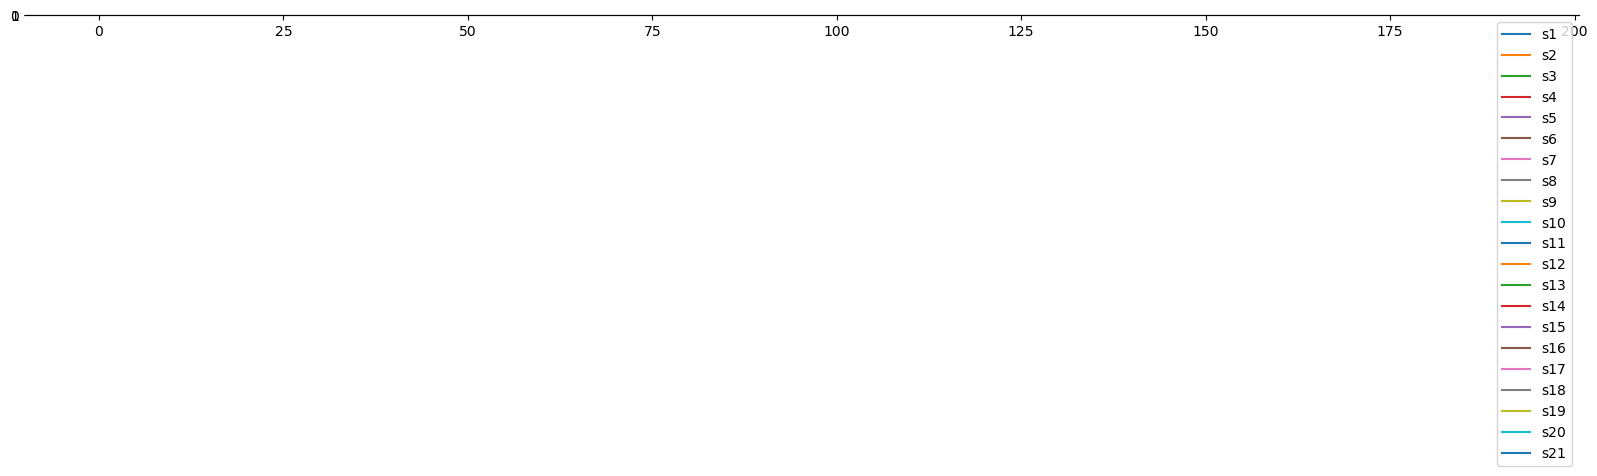

In [17]:
sensor_cols= cols_names[5:]
train_df[train_df.id==1][sensor_cols].plot(figsize=(20,0))

<Axes: >

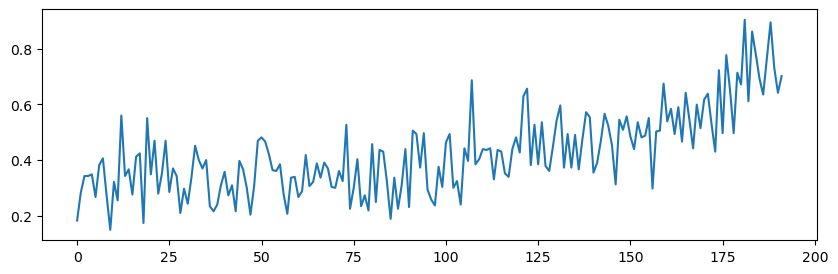

In [18]:
train_df[train_df.id==1][sensor_cols[1]].plot(figsize=(10,3))

SENSOR 1 VALUES INCREASE WHEN THE CYLCE OF NUMBER INCREASES.
SENSOR 6 VALUES DECREASE WHEN THE CYCLE IF NUMBER INCREASES.
MOST OTHER SENSORS EXHIBIT EITHER AN INCREASING OR DECREASING LEVEL.


<Axes: >

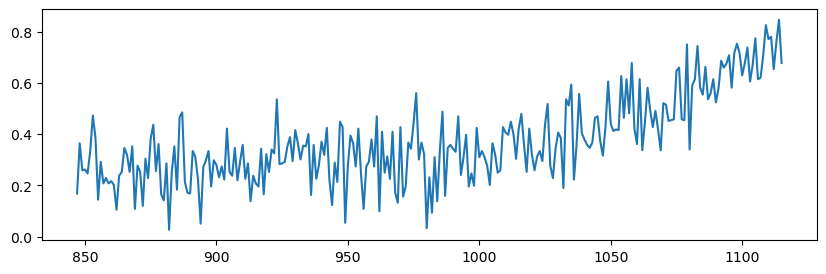

In [19]:
train_df[train_df.id==5][sensor_cols[1]].plot(figsize=(10, 3))

<Axes: >

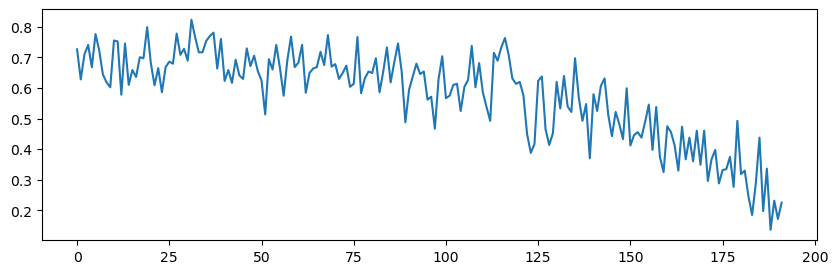

In [20]:
train_df[train_df.id==1][sensor_cols[6]].plot(figsize=(10, 3))

SINCE WE HAVE PLOTTED SENSOR 1 OBSERVATIONS FOR ID 1 AND ID 5.
BOTH OBSERVATIONS HAVE AN UPWARD TREND WITH INCREASING CYCLES.


<Axes: >

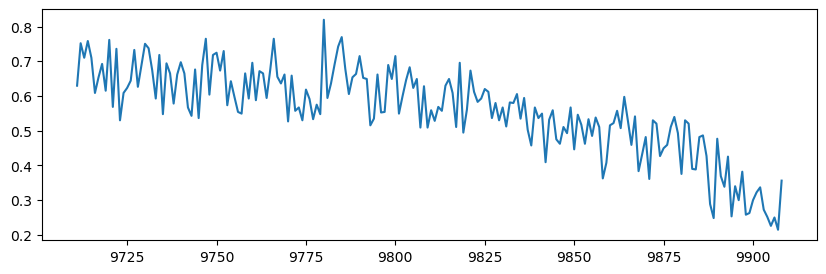

In [21]:
train_df[train_df.id==50][sensor_cols[6]].plot(figsize=(10, 3))

WE HAVE PLOTTED SENSOR 6 OBSERVATIONS FOR ID 1 AND ID 50.
BOTH OBSERVATIONS HAVE A DOWNWARD TREND WITH INCREASING CYCLES.
WE CAN SEE THAT WHEN THE SENSOR VALUES APPROACH A PARTICULAR VALUE, THE AIRCRAFT MAY FAIL TO WORK SOON.


GENERATING INPUT SEQUENCE


In [22]:
sequence_length= 50

# FUNCTION TO GENERATE SEQUENCE
def sequence_generator(feature_df, seq_length, seq_cols):
    feature_array= feature_df[seq_cols].values
    num_elements= feature_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

In [23]:
# GENERATING SEQUENCES FOR EACH ENGINE ID.
# UNIQUE() RETURNS ALL THE UNIQUE IDS IN A LIST.
seq_gen= (list(sequence_generator(train_df[train_df['id']==id], sequence_length, ["s2"]))
          for id in train_df['id'].unique())

seq_set= np.concatenate(list(seq_gen)).astype(np.float32)

# LET'S PRINT THE SHAPE OF THE SEQ_SET
seq_set.shape

(15631, 50, 1)

In [24]:
# FUNTION TO GENERATE LABELS IS AS FOLLOWS:
def label_generator(label_df, seq_length, label):
    label_array= label_df[label].values
    num_elements= label_array.shape[0]
    return label_array[seq_length:num_elements, :]

In [25]:
label_gen= [label_generator(train_df[train_df['id']==id], sequence_length, ['failure_within_w1'])
            for id in train_df['id'].unique()]
label_set= np.concatenate(label_gen).astype(np.float32)
label_set.shape

(15631, 1)

RNN MODELS

1. SIMPLE RNN [1 FEATURE]
2. SIMPLE RNN [25 FEATURES]
3. BI-DIRECTIONAL RNN [25 FEATURES]


1. SIMPLE RNN [1 FEATURE]


In [32]:
out_dim= label_set.shape[1]
features_dim= seq_set.shape[2]

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd= Sequential()

RNN_fwd.add(SimpleRNN(
    input_shape=(sequence_length, features_dim), units=1, return_sequences=False))
RNN_fwd.add(Dropout(0.2))

RNN_fwd.add(Dense(units=out_dim, activation='sigmoid'))
# COMPILE THE MODEL
RNN_fwd.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(RNN_fwd.summary())

# DEFINE THE PATH TO SAVE THE MDOEL
RNN_fwd_path= 'C:/Users/samar/OneDrive/Desktop/Programs/Personal-Project/Aircraft-Predictive-Maintenance/RNN_fwd.keras'

Features dimension:  1
Output dimension:  1


c:\Users\samar\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (20.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [33]:
import time
epochs= 300
batch_size= 200
start= time.time()

# FITTING THE NETWORK
RNN_fwd_history= RNN_fwd.fit(seq_set, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'), keras.callbacks.ModelCheckpoint(RNN_fwd_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
end= time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), "secs")

Epoch 1/300
75/75 - 2s - 32ms/step - accuracy: 0.3169 - loss: 1.1301 - val_accuracy: 0.1982 - val_loss: 1.0398
Epoch 2/300
75/75 - 0s - 5ms/step - accuracy: 0.3169 - loss: 1.0028 - val_accuracy: 0.1982 - val_loss: 0.9064
Epoch 3/300
75/75 - 0s - 5ms/step - accuracy: 0.3495 - loss: 0.8328 - val_accuracy: 0.3824 - val_loss: 0.7129
Epoch 4/300
75/75 - 0s - 5ms/step - accuracy: 0.6739 - loss: 0.6322 - val_accuracy: 0.9309 - val_loss: 0.5396
Epoch 5/300
75/75 - 0s - 5ms/step - accuracy: 0.8869 - loss: 0.5137 - val_accuracy: 0.8645 - val_loss: 0.4733
Epoch 6/300
75/75 - 0s - 4ms/step - accuracy: 0.8557 - loss: 0.4707 - val_accuracy: 0.8363 - val_loss: 0.4481
Epoch 7/300
75/75 - 0s - 5ms/step - accuracy: 0.8585 - loss: 0.4486 - val_accuracy: 0.8760 - val_loss: 0.4254
Epoch 8/300
75/75 - 0s - 5ms/step - accuracy: 0.8788 - loss: 0.4274 - val_accuracy: 0.8939 - val_loss: 0.4000
Epoch 9/300
75/75 - 0s - 5ms/step - accuracy: 0.8894 - loss: 0.4060 - val_accuracy: 0.9015 - val_loss: 0.3783
Epoch 10/

MODEL EVALUATION ON THE TRAIN AND VALIDATION SETS


In [30]:
def plot_model_accuracy(model_name_history, width=10, height=10):
    fig_acc= plt.figure(figsize=(width, height))
    plt.plot(model_name_history.history['accuracy'])
    plt.plot(model_name_history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

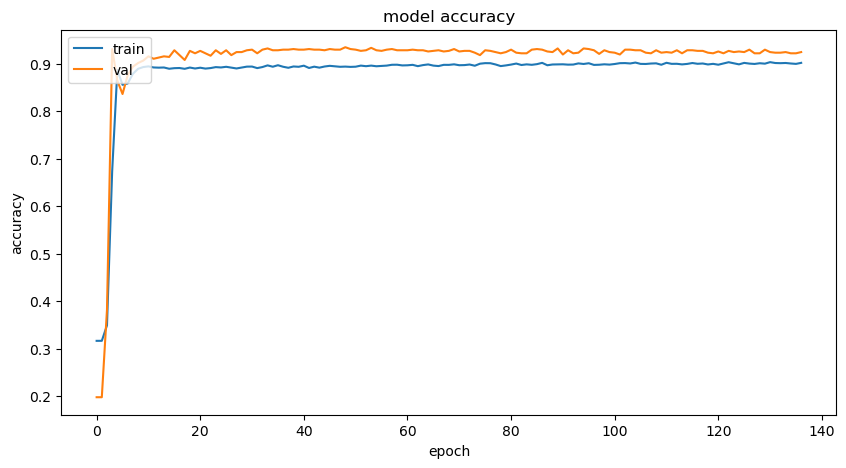

In [34]:
# CALLING THE FUNCTION
plot_model_accuracy(RNN_fwd_history, 10, 5)

TRAINING CURVE


In [35]:
def plot_training_curve(model_name_history, width=10, height=10):
    fig_acc= plt.figure(figsize=(width, height))
    plt.plot(model_name_history.history['loss'])
    plt.plot(model_name_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

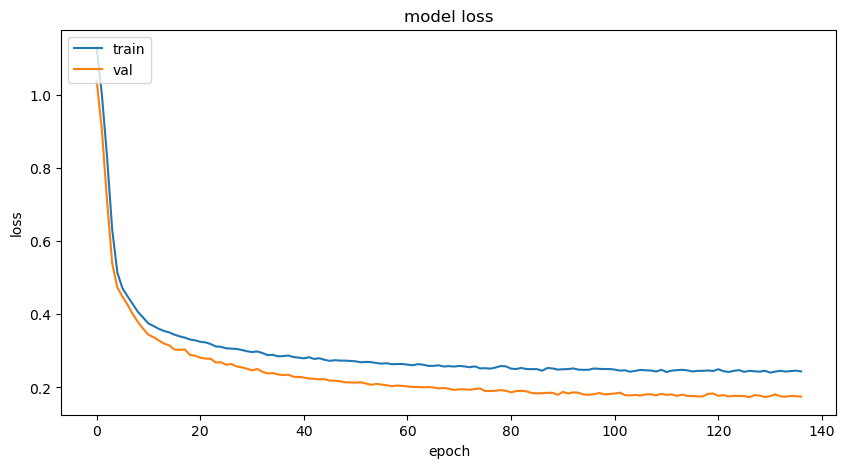

In [36]:
# CALLING THE FUNCTION
plot_training_curve(RNN_fwd_history, 10, 5)

MODEL EVALUATION ON THE TRAIN SET


In [56]:
def analyze_model_on_train_set(input_sequence_set, model_name):
    model_history_scores= model_name.evaluate(input_sequence_set, label_set, verbose=1, batch_size=50)
    print('Train Accuracy: {}'.format(model_history_scores[1]))
    # MAKE PREDICTIONS AND COMPUTE THE CONFUSION MATRIX
    y_pred= (model_name.predict(input_sequence_set, verbose=1, batch_size=200) > 0.5).astype("int32")
    
    y_pred_flat= y_pred.flatten()
    y_true_flat= label_set.flatten()
    
    test_set= pd.DataFrame(y_pred_flat, columns=['Predictions'])
    test_set.to_csv('binary_sub,it_train.csv', index=None)
    print('Confusion Matrix\n- x-axis is true labels. \n- y-axis is predicted labels')
    model_cm= confusion_matrix(y_true_flat, y_pred_flat)
    print(model_cm)
    
    # COMPUTE THE PRECISION AND RECALL.
    model_precision= precision_score(y_true_flat, y_pred)
    model_recall= recall_score(y_true_flat, y_pred)
    print('Train Precision= ', model_precision, '\n', 'Train Recall= ', model_recall)
    
# CALLING THE FUNCTION
analyze_model_on_train_set(seq_set, RNN_fwd)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9282 - loss: 0.1829
Train Accuracy: 0.9263643026351929
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix
- x-axis is true labels. 
- y-axis is predicted labels
[[12113   418]
 [  733  2367]]
Train Precision=  0.8499102333931777 
 Train Recall=  0.7635483870967742


MODEL EVALUATION ON TEST SET


In [43]:
def analyze_model_on_test_set(input_sequence_columns, model_path, width=10, height=5):
    last_test_seq= [test_df[test_df['id']==id][input_sequence_columns].values[-sequence_length:] for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
    last_test_seq= np.asarray(last_test_seq).astype(np.float32)
    
    y_mask= [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
    last_test_label= test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
    last_test_label= last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)
    
    # IF THE BEST MODEL WEIGHTS WERE SAVED, LOAD THEM.
    if os.path.isfile(model_path):
        print("using" + model_path)
        model_estimator= load_model(model_path)
        
    # TEST THE METRICS
    start= time.time()
    score_test= model_estimator.evaluate(last_test_seq, last_test_label, verbose=2)
    end= time.time()
    print("Total time taken for interfacing: ", "{:.2f}".format((end-start)), "secs")
    print('Test Accuracy: {}'.format(score_test[1]))
    
    # MAKE PREDICTIONS AND COMPUTE THE CONFUSION MATRIX.
    y_model_estimator_pred_test= (model_estimator.predict(last_test_seq) > 0.5).astype("int32")
    y_true_test= last_test_label
    
    test_set= pd.DataFrame(y_model_estimator_pred_test)
    test_set.to_csv('binary_submit_test.csv', index=None)
    print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
    
    model_estimator_conf_m= confusion_matrix(y_true_test, y_model_estimator_pred_test)
    print(model_estimator_conf_m)
    
    # COMPUTE THE PRECISION AND RECALL VALUES
    model_estimator_precision_test= precision_score(y_true_test, y_model_estimator_pred_test)
    model_estimator_recall_test= recall_score(y_true_test, y_model_estimator_pred_test)
    f1_test= 2*(model_estimator_precision_test * model_estimator_recall_test) / (model_estimator_precision_test + model_estimator_recall_test)
    print('Test Precision: ', model_estimator_precision_test, '\n', 'Test Recall: ', model_estimator_recall_test, '\n', 'Test F1-score: ', f1_test)
    
    # PLOT THE PREDICTED DATA IN BLUE AND THE ACTUAL DATA IN GREEN TO VISUALLY VERIFY THE ACCURACY OF THE MODEL.
    fig_verify= plt.figure(figsize=(10, 5))
    plt.plot(y_model_estimator_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()

usingC:/Users/samar/OneDrive/Desktop/Programs/Personal-Project/Aircraft-Predictive-Maintenance/RNN_fwd.keras
3/3 - 0s - 112ms/step - accuracy: 0.9032 - loss: 0.2675
Total time taken for interfacing:  0.37 secs
Test Accuracy: 0.9032257795333862
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 8 17]]
Test Precision:  0.9444444444444444 
 Test Recall:  0.68 
 Test F1-score:  0.7906976744186047


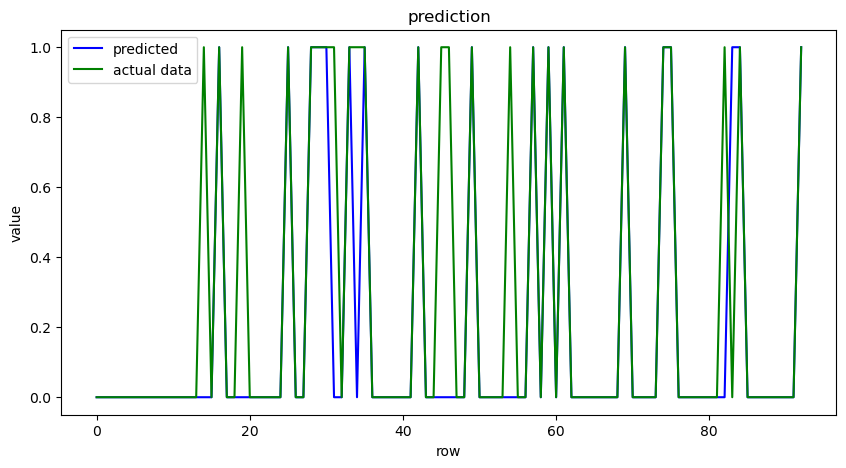

In [44]:
# CALLING THE FUNCTION
analyze_model_on_test_set(["s2"], RNN_fwd_path, 10, 5)

SIMPLE RNN WITH 25 FEATURES


In [45]:
# PICKING THE FEATURE COLUMNS
sensor_cols= ['s' + str(i) for i in range(1,22)]
sequence_cols_25= ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols_25.extend(sensor_cols)

In [47]:
# GENERATING SEQUENCES FOR EACH ENGINE ID. 
# UNIQUE() RETURNS ALL THE UNIQUE IDS IN A LIST.

seq_gen= (list(sequence_generator(train_df[train_df['id']==id], sequence_length, sequence_cols_25)) for id in train_df['id'].unique())
 
seq_set_f25= np.concatenate(list(seq_gen)).astype(np.float32)
 
seq_set_f25.shape

(15631, 50, 25)

In [48]:
features_dim= seq_set_f25.shape[2]
out_dim= label_set.shape[1]

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd_2= Sequential()

RNN_fwd_2.add(SimpleRNN(
    input_shape=(sequence_length, features_dim), units=5, return_sequences=True))
RNN_fwd_2.add(Dropout(0.2))
RNN_fwd_2.add(SimpleRNN(
    units=3, return_sequences=False))
RNN_fwd_2.add(Dropout(0.2))
RNN_fwd_2.add(Dense(units=out_dim, activation='sigmoid'))

# COMPILE THE MODEL
RNN_fwd_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_fwd_2.summary())

# DEFINE THE PATH TO SAVE THE MODEL.
RNN_fwd_2_path= "C:/Users/samar/OneDrive/Desktop/Programs/Personal-Project/Aircraft-Predictive-Maintenance/RNN_fwd_2.keras"

Features dimension:  25
Output dimension:  1


c:\Users\samar\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 50, 5)          │           155 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186 (744.00 B)

 Trainable params: 186 (744.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [49]:
import time
epochs= 200
batch_size= 200
start= time.time()

# FITTING THE NETWORK.
RNN_fwd_2_history= RNN_fwd_2.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2, callbacks= [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'), keras.callbacks.ModelCheckpoint(RNN_fwd_2_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

end= time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), "secs")

Epoch 1/200
75/75 - 3s - 44ms/step - accuracy: 0.6475 - loss: 0.6472 - val_accuracy: 0.8018 - val_loss: 0.5528
Epoch 2/200
75/75 - 1s - 9ms/step - accuracy: 0.7952 - loss: 0.5567 - val_accuracy: 0.8018 - val_loss: 0.5252
Epoch 3/200
75/75 - 1s - 9ms/step - accuracy: 0.8009 - loss: 0.5304 - val_accuracy: 0.8018 - val_loss: 0.4761
Epoch 4/200
75/75 - 1s - 9ms/step - accuracy: 0.8226 - loss: 0.4593 - val_accuracy: 0.8018 - val_loss: 0.4069
Epoch 5/200
75/75 - 1s - 8ms/step - accuracy: 0.8473 - loss: 0.3876 - val_accuracy: 0.8964 - val_loss: 0.3431
Epoch 6/200
75/75 - 1s - 8ms/step - accuracy: 0.8926 - loss: 0.3291 - val_accuracy: 0.9258 - val_loss: 0.3014
Epoch 7/200
75/75 - 1s - 8ms/step - accuracy: 0.9157 - loss: 0.2898 - val_accuracy: 0.9258 - val_loss: 0.2719
Epoch 8/200
75/75 - 1s - 8ms/step - accuracy: 0.9257 - loss: 0.2631 - val_accuracy: 0.9335 - val_loss: 0.2407
Epoch 9/200
75/75 - 1s - 8ms/step - accuracy: 0.9287 - loss: 0.2461 - val_accuracy: 0.9437 - val_loss: 0.2103
Epoch 10/

PLOTTING MODEL ACCURACY FOR THE TRAIN AND VALIDATION SETS


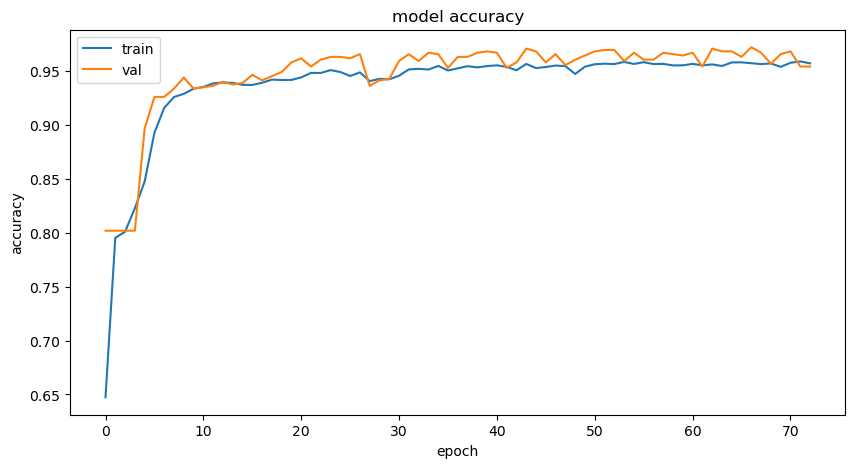

In [50]:
plot_model_accuracy(RNN_fwd_2_history, 10, 5)

TRAINING CURVE


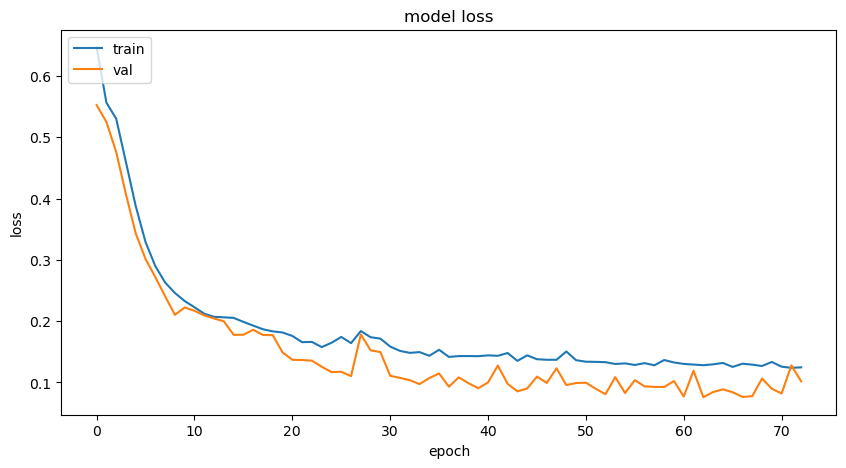

In [51]:
plot_training_curve(RNN_fwd_2_history, 10, 5)

MODEL EVALUATION ON TRAIN SET


In [57]:
analyze_model_on_train_set(seq_set_f25, RNN_fwd_2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9572 - loss: 0.1143
Train Accuracy: 0.956816554069519
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Confusion Matrix
- x-axis is true labels. 
- y-axis is predicted labels
[[12420   111]
 [  564  2536]]
Train Precision=  0.9580657347941065 
 Train Recall=  0.8180645161290323


MODEL EVALUATION ON TEST SET


usingC:/Users/samar/OneDrive/Desktop/Programs/Personal-Project/Aircraft-Predictive-Maintenance/RNN_fwd_2.keras
3/3 - 0s - 161ms/step - accuracy: 0.9140 - loss: 0.2191
Total time taken for interfacing:  0.52 secs
Test Accuracy: 0.9139785170555115
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[65  3]
 [ 5 20]]
Test Precision:  0.8695652173913043 
 Test Recall:  0.8 
 Test F1-score:  0.8333333333333333


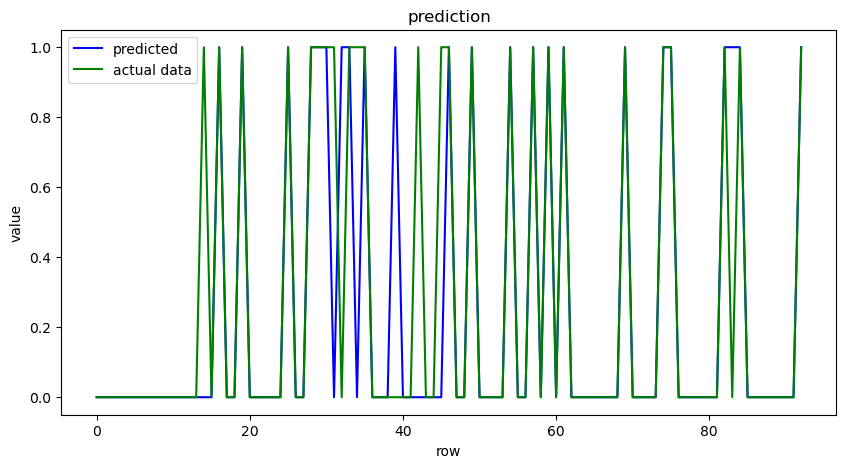

In [58]:
analyze_model_on_test_set(sequence_cols_25, RNN_fwd_2_path, 10, 5)

BIDIRECTIONAL RNN


In [60]:
# IMPORTING BIDIRECTIONAL LIBRARY.
from tensorflow.keras.layers import Bidirectional
features_dim= seq_set_f25.shape[2]
out_dim= label_set.shape[1]

print("Feature Dimension: ", features_dim)
print("Output Dimension: ", out_dim)

RNN_bi= Sequential()

RNN_bi.add(Bidirectional(SimpleRNN(
    input_shape=(sequence_length, features_dim), units=6, return_sequences=True)))
RNN_bi.add(Dropout(0.2))
RNN_bi.add(SimpleRNN(units=3, return_sequences=False))
RNN_bi.add(Dropout(0.2))
RNN_bi.add(Dense(units=out_dim, activation= 'sigmoid'))

# COMPILE THE MODEL
RNN_bi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# DEFINE THE PATH TO SAVE THE MODEL
RNN_bi_path= 'C:/Users/samar/OneDrive/Desktop/Programs/Personal-Project/Aircraft-Predictive-Maintenance/RNN_bi.keras'

Feature Dimension:  25
Output Dimension:  1


c:\Users\samar\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
import time
epochs= 200
batch_size= 200
start= time.time()

RNN_bi_history= RNN_bi.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'), keras.callbacks.ModelCheckpoint(RNN_bi_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
end=time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), "secs")

Epoch 1/200
75/75 - 4s - 60ms/step - accuracy: 0.7005 - loss: 0.5952 - val_accuracy: 0.8018 - val_loss: 0.4672
Epoch 2/200
75/75 - 1s - 10ms/step - accuracy: 0.7919 - loss: 0.4840 - val_accuracy: 0.8018 - val_loss: 0.4079
Epoch 3/200
75/75 - 1s - 10ms/step - accuracy: 0.8306 - loss: 0.4021 - val_accuracy: 0.8951 - val_loss: 0.2846
Epoch 4/200
75/75 - 1s - 10ms/step - accuracy: 0.9129 - loss: 0.2831 - val_accuracy: 0.9233 - val_loss: 0.2173
Epoch 5/200
75/75 - 1s - 10ms/step - accuracy: 0.9273 - loss: 0.2434 - val_accuracy: 0.9425 - val_loss: 0.2086
Epoch 6/200
75/75 - 1s - 10ms/step - accuracy: 0.9314 - loss: 0.2230 - val_accuracy: 0.9309 - val_loss: 0.1906
Epoch 7/200
75/75 - 1s - 10ms/step - accuracy: 0.9359 - loss: 0.2082 - val_accuracy: 0.9297 - val_loss: 0.1782
Epoch 8/200
75/75 - 1s - 10ms/step - accuracy: 0.9335 - loss: 0.2069 - val_accuracy: 0.9373 - val_loss: 0.1797
Epoch 9/200
75/75 - 1s - 9ms/step - accuracy: 0.9364 - loss: 0.1960 - val_accuracy: 0.9373 - val_loss: 0.1698
Ep

In [62]:
# PRINT THE SUMMARY OF THE MODEL
print(RNN_bi.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 50, 12)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 3)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,310 (5.12 KB)

 Trainable params: 436 (1.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 874 (3.42 KB)

None


PLOT MODEL ACCURACY FOR TRAIN AND VALIDATION SET


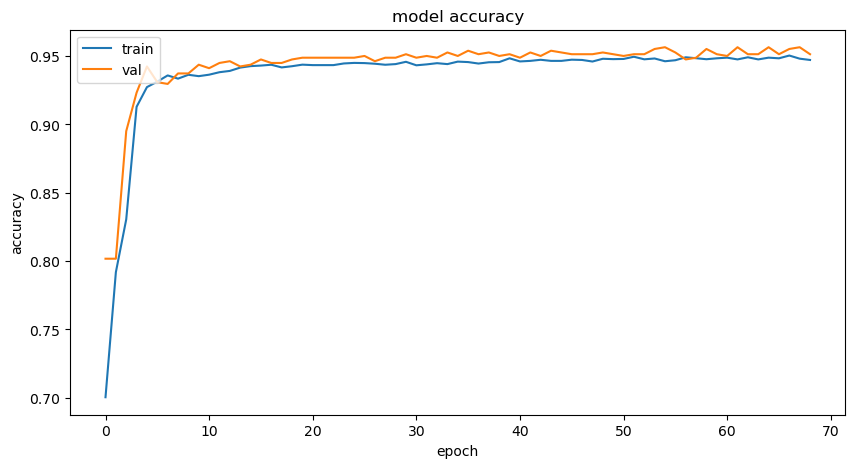

In [63]:
plot_model_accuracy(RNN_bi_history, 10, 5)

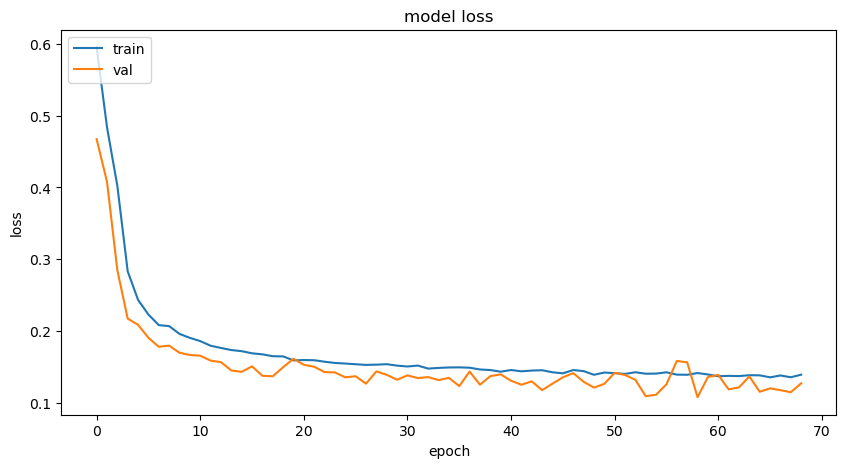

In [64]:
plot_training_curve(RNN_bi_history, 10, 5)

MODEL EVALUATION ON TRAIN SET


In [65]:
analyze_model_on_train_set(seq_set_f25, RNN_bi)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9565 - loss: 0.1084
Train Accuracy: 0.9529780745506287
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Confusion Matrix
- x-axis is true labels. 
- y-axis is predicted labels
[[12270   261]
 [  474  2626]]
Train Precision=  0.909594735019051 
 Train Recall=  0.8470967741935483


MODEL EVALUATION ON TEST SET


usingC:/Users/samar/OneDrive/Desktop/Programs/Personal-Project/Aircraft-Predictive-Maintenance/RNN_bi.keras
3/3 - 1s - 222ms/step - accuracy: 0.9032 - loss: 0.1973
Total time taken for interfacing:  0.72 secs
Test Accuracy: 0.9032257795333862
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[66  2]
 [ 7 18]]
Test Precision:  0.9 
 Test Recall:  0.72 
 Test F1-score:  0.7999999999999999


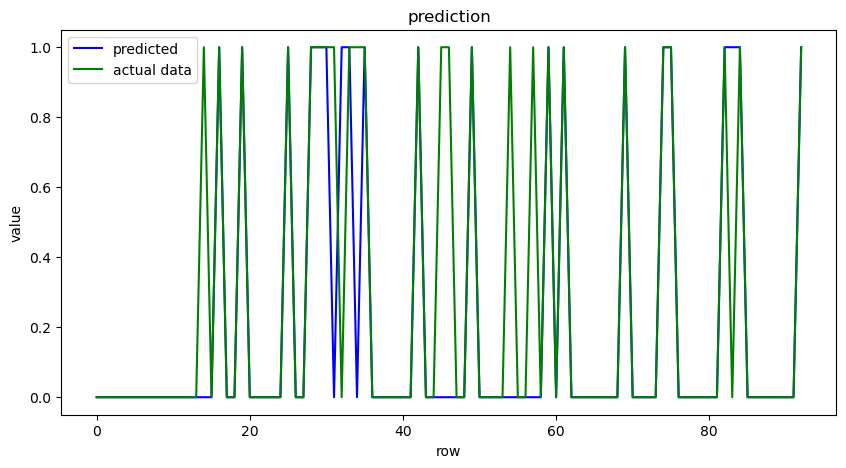

In [66]:
analyze_model_on_test_set(sequence_cols_25, RNN_bi_path, 10, 5)

RNN SUMMARY

1. The performance of the RNN with one feature on the test set is worse than that of a more complex RNN.
2. RNN model with increased units with all 25 features achieves better accuracy and other evaluation metrics
3. When we use more than one layer, the previous layer must be set to return_sequences= True


MODEL BUILDING WITH LSTM


In [67]:
features_dim= seq_set_f25.shape[2]
out_dim= label_set.shape[1]

print("Feature Dimension: ", features_dim)
print("Output Dimension: ", out_dim)

model= Sequential()

model.add(LSTM(input_shape=(sequence_length, features_dim), units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=out_dim, activation='sigmoid'))

# COMPILE THE MODEL
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# DEFINE PATH TO SAVE MODEL
model_path= 'C:/Users/samar/OneDrive/Desktop/Programs/Personal-Project/Aircraft-Predictive-Maintenance/binary_model.keras'

Feature Dimension:  25
Output Dimension:  1


c:\Users\samar\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 100)        │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,651 (315.04 KB)

 Trainable params: 80,651 (315.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [68]:
import time
epochs= 200
batch_size= 200
start= time.time()

# FITTING THE NETWORK
history= model.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'), keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

end= time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), "secs")

Epoch 1/200
75/75 - 12s - 155ms/step - accuracy: 0.8941 - loss: 0.2439 - val_accuracy: 0.9476 - val_loss: 0.1197
Epoch 2/200
75/75 - 8s - 110ms/step - accuracy: 0.9646 - loss: 0.0877 - val_accuracy: 0.9680 - val_loss: 0.0850
Epoch 3/200
75/75 - 9s - 119ms/step - accuracy: 0.9667 - loss: 0.0823 - val_accuracy: 0.9859 - val_loss: 0.0404
Epoch 4/200
75/75 - 9s - 120ms/step - accuracy: 0.9704 - loss: 0.0725 - val_accuracy: 0.9898 - val_loss: 0.0333
Epoch 5/200
75/75 - 9s - 126ms/step - accuracy: 0.9686 - loss: 0.0750 - val_accuracy: 0.9706 - val_loss: 0.0751
Epoch 6/200
75/75 - 10s - 129ms/step - accuracy: 0.9727 - loss: 0.0662 - val_accuracy: 0.9936 - val_loss: 0.0264
Epoch 7/200
75/75 - 9s - 119ms/step - accuracy: 0.9741 - loss: 0.0599 - val_accuracy: 0.9578 - val_loss: 0.0993
Epoch 8/200
75/75 - 8s - 111ms/step - accuracy: 0.9758 - loss: 0.0596 - val_accuracy: 0.9795 - val_loss: 0.0420
Epoch 9/200
75/75 - 8s - 110ms/step - accuracy: 0.9754 - loss: 0.0563 - val_accuracy: 0.9706 - val_los

MODEL EVALUATION ON VALIDATION SET


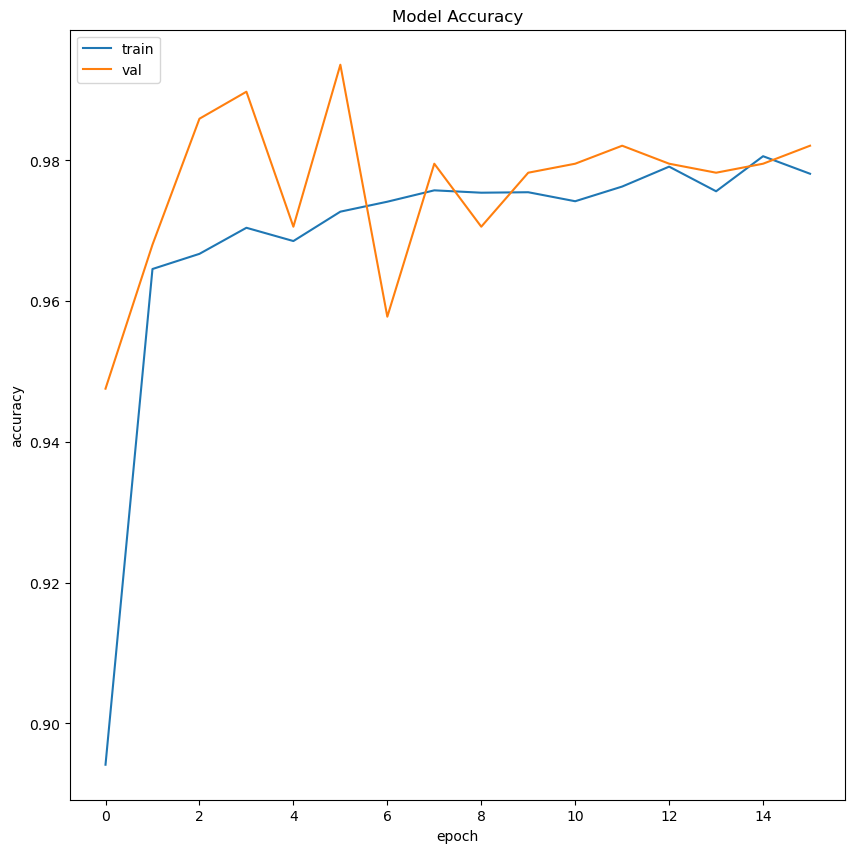

In [69]:
# PLOTTING THE CHANGE IN MODEL ACCURACY ON TRAIN AND VAL SETS
fig_acc= plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

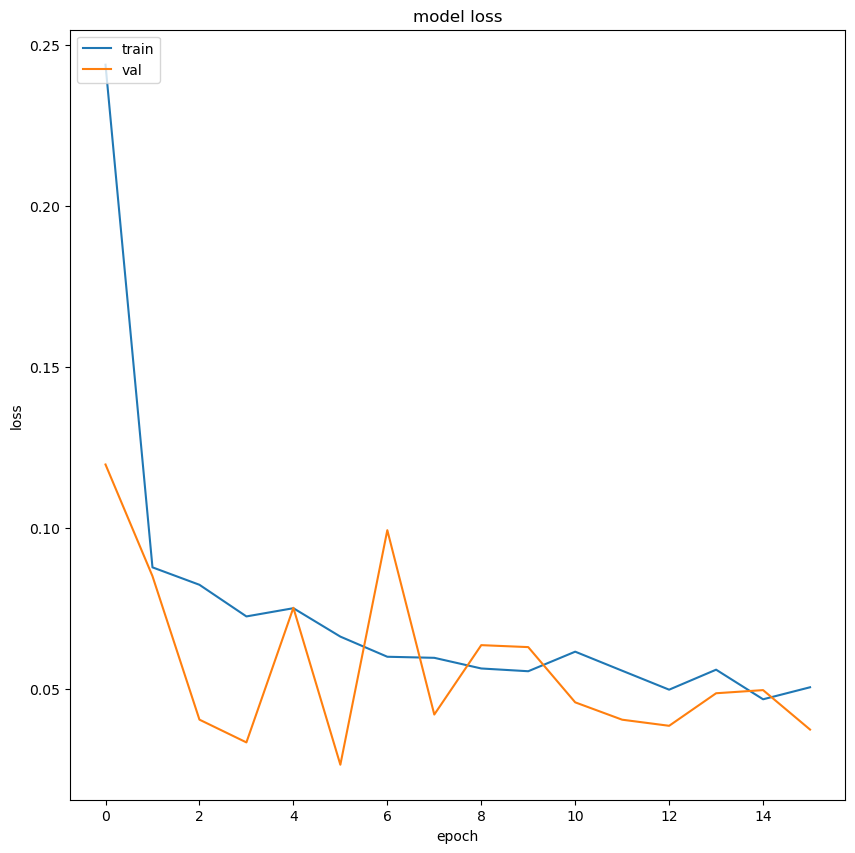

In [70]:
# Plot model loss for train and test sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [71]:
# Training metrics
scores = model.evaluate(seq_set_f25, label_set, verbose=1, batch_size=50)
print('Train Accurracy: {}'.format(scores[1]))

# Make predictions and compute confusion matrix
y_pred = (model.predict(seq_set_f25, verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_set

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'Train Precision = ', precision, '\n', 'Train Recall = ', recall)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9856 - loss: 0.0387
Train Accurracy: 0.9841340780258179
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12357   174]
 [   74  3026]]
Train Precision =  0.945625 
 Train Recall =  0.9761290322580645


MODEL EVALUATION ON TEST SET


3/3 - 1s - 178ms/step - accuracy: 0.9892 - loss: 0.0465
Total time taken for inferencing:  0.58  secs
Test Accurracy: 0.9892473220825195
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 0 25]]
Test Precision:  0.9615384615384616 
 Test Recall:  1.0 
 Test F1-score: 0.9803921568627451


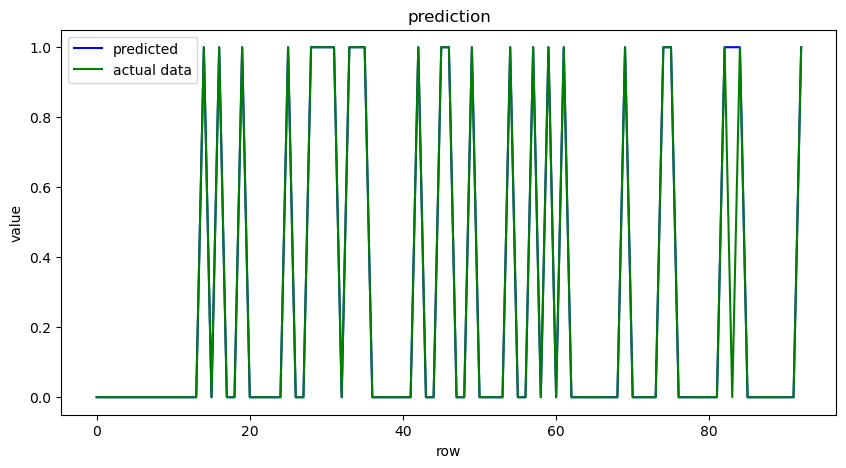

In [72]:
# Considering all the last sequences of test set
last_test_seq = [test_df[test_df['id']==id][sequence_cols_25].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
last_test_seq = np.asarray(last_test_seq).astype(np.float32)

# Get labels of test set
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

# If best model weights were saved then load it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# Test metrics
start = time.time()
scores_test = estimator.evaluate(last_test_seq, last_test_label, verbose=2)
end = time.time()
print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

print('Test Accurracy: {}'.format(scores_test[1]))

# Make predictions and compute confusion matrix
y_pred_test = (estimator.predict(last_test_seq) > 0.5).astype("int32")
y_true_test = last_test_label

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
conf_m = confusion_matrix(y_true_test, y_pred_test)
print(conf_m)

# Compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test,'\n', 'Test F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# Actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()

PROJECT END
